Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                               texto  etiqueta
0  Intenté bailar y terminé en el suelo, todos se...         1
1   Tu sonrisa ilumina incluso los días más oscuros.         2
2  No puedo creer que me trataran de esa manera, ...         5
3            Finalmente me gradué, ¡estoy tan feliz!         3
4  Olvidé la letra de la canción durante la prese...         6


Modelo cargado desde /content/drive/My Drive/modelo_emociones.h5
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 1.0000 - loss: 4.7847e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - accuracy: 1.0000 - loss: 6.6932e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 1.0000 - loss: 1.5628e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 1.0000 - loss: 1.4407e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.9988 - loss: 0.0031
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - accuracy: 0.9807 - loss: 0.1722
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.9991 - loss: 0.0108
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.9906 - loss: 0.0450
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.9619 - loss: 0.1311
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.9979 - loss: 0.0032


Modelo entrenado
Modelo guardado en /content/drive/My Drive/modelo_emociones.h5


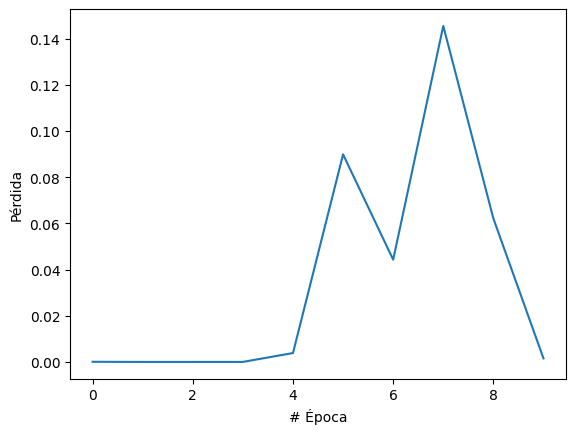

Ingresa una frase para analizar la emoción (o escribe 'salir' para terminar): mi gato es bonito
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Emoción predicha: miedo
¿Es esta predicción correcta? (sí/no): no
¿Cuál es la emoción correcta? romántico
Retroalimentación recibida y almacenada.
Ingresa una frase para analizar la emoción (o escribe 'salir' para terminar): me gane el lotto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Emoción predicha: feliz
¿Es esta predicción correcta? (sí/no): si
Predicción correcta según la retroalimentación.
Ingresa una frase para analizar la emoción (o escribe 'salir' para terminar): por que va a llover justo hoy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Emoción predicha: feliz
¿Es esta predicción correcta? (sí/no): no
¿Cuál es la emoción correcta? ira
Retroalimentación recibida y almacenada.


In [ ]:
from google.colab import drive
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam


drive.mount('/content/drive')


csv_path = '/content/drive/My Drive/emociones_grande.csv'
modelo_path = '/content/drive/My Drive/modelo_emociones.h5'
feedback_csv_path = '/content/drive/My Drive/feedback_emociones.csv'


data = pd.read_csv(csv_path)


print(data.head())


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['texto'])
sequences = tokenizer.texts_to_sequences(data['texto'])
padded_sequences = pad_sequences(sequences, padding='post')


etiquetas = np.array(data['etiqueta'])

def guardar_modelo(modelo):
    """Guarda el modelo en un archivo HDF5."""
    modelo.save(modelo_path)
    print(f"Modelo guardado en {modelo_path}")

def cargar_modelo():
    """Carga el modelo desde un archivo HDF5."""
    try:
        modelo = load_model(modelo_path)
        print(f"Modelo cargado desde {modelo_path}")
        return modelo
    except IOError:
        print(f"No se encontró el modelo en {modelo_path}. Se creará un nuevo modelo.")
        return None

modelo = cargar_modelo()


if modelo is None:
    modelo = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=padded_sequences.shape[1]),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(256, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(128)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(7, activation='softmax')
    ])


modelo.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


historial = modelo.fit(padded_sequences, etiquetas, epochs=10, verbose=1)
print("Modelo entrenado")


guardar_modelo(modelo)


plt.xlabel("# Época")
plt.ylabel("Pérdida")
plt.plot(historial.history["loss"])
plt.show()


emociones = ['tristeza', 'gracioso', 'romántico', 'feliz', 'miedo', 'ira', 'vergüenza']

# Leer el archivo de feedback existente si existe
def leer_feedback():
    try:
        feedback_data = pd.read_csv(feedback_csv_path)
        frases = feedback_data['texto'].tolist()
        etiquetas = feedback_data['etiqueta'].tolist()
        return frases, etiquetas
    except FileNotFoundError:
        return [], []

# Inicializar listas de retroalimentación con datos existentes
frases_incorrectas, emociones_correctas = leer_feedback()

while True:
    nueva_frase = [input("Ingresa una frase para analizar la emoción (o escribe 'salir' para terminar): ")]

    if nueva_frase[0].lower() == 'salir':
        print("Finalizando el análisis.")
        break

    nueva_secuencia = tokenizer.texts_to_sequences(nueva_frase)
    nueva_secuencia_padded = pad_sequences(nueva_secuencia, maxlen=padded_sequences.shape[1], padding='post')

    prediccion = modelo.predict(nueva_secuencia_padded)
    etiqueta_predicha = np.argmax(prediccion)

    print(f"Emoción predicha: {emociones[etiqueta_predicha]}")


    feedback = input("¿Es esta predicción correcta? (sí/no): ")

    if feedback.lower() == "no":
        emocion_correcta = input("¿Cuál es la emoción correcta? ")
        if emocion_correcta in emociones:
            frases_incorrectas.append(nueva_frase[0])
            emociones_correctas.append(emociones.index(emocion_correcta))
            print("Retroalimentación recibida y almacenada.")
        else:
            print("Emoción correcta no reconocida.")

    else:
        print("Predicción correcta según la retroalimentación.")

# Solo reentrenar si hay datos de retroalimentación nuevos
if frases_incorrectas:
    nuevas_secuencias = tokenizer.texts_to_sequences(frases_incorrectas)
    nuevas_secuencias_padded = pad_sequences(nuevas_secuencias, maxlen=padded_sequences.shape[1], padding='post')
    nuevas_etiquetas = np.array(emociones_correctas)

    combinado_secuencias = np.concatenate([padded_sequences, nuevas_secuencias_padded])
    combinado_etiquetas = np.concatenate([etiquetas, nuevas_etiquetas])

    historial = modelo.fit(combinado_secuencias, combinado_etiquetas, epochs=5, verbose=1)

    guardar_modelo(modelo)
    print(f"Modelo reentrenado y guardado en '{modelo_path}'.")

    # Guardar los datos de feedback en el archivo CSV
    feedback_data = pd.DataFrame({
        'texto': frases_incorrectas,
        'etiqueta': emociones_correctas
    })
    feedback_data.to_csv(feedback_csv_path, mode='a', header=False, index=False)
    print(f"Datos de feedback acumulados en '{feedback_csv_path}'.")

print("Entrenamiento incrementado finalizado.")


In [17]:
!pip install tensorflow
